# Spam Detection LSTM

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
! curl -o "data/spam.csv" "https://lazyprogrammer.me/course_files/spam.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  491k  100  491k    0     0  2031k      0 --:--:-- --:--:-- --:--:-- 2049k


In [3]:
# Questo file ha un encoding un po' particolare, per leggerlo dobbiamo passarglielo:
# 'utf-8' codec can't decode bytes in position 606-607: invalid continuation byte
df = pd.read_csv("data/spam.csv", encoding="ISO-8859-1")

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df.dropna(axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.columns = ["label", "data"]
df

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
# alternativa: df["b_label"] =df["b_label"] = (df["label"] == "spam")
df["b_label"] = df["label"].map({"ham": 0, "spam": 1})
df

,label,data,b_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [9]:
y = df["b_label"].values

In [10]:
df_train, df_test, y_train, y_test = train_test_split(df["data"], y, test_size=0.33)

In [11]:
MAX_VOCAB_SIZE = 20_000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
seq_train = tokenizer.texts_to_sequences(df_train)
seq_test = tokenizer.texts_to_sequences(df_test)

In [12]:
word2idx = tokenizer.word_index
V = len(word2idx)
V

7181

In [13]:
data_train = pad_sequences(seq_train)
data_train.shape

(3733, 189)

In [14]:
T = data_train.shape[1]

In [15]:
data_test = pad_sequences(seq_test, maxlen=T)

In [16]:
D = 20 # Embedding Dim
M = 15 # Hidden State Dim

# Nota sull'embedding: quella che noi inseriamo all'interno del codice è la vocabSize, ovvero la grandezza del vocabolario (numero di parole).
# Siccome abbiamo una vocab size di 7159, se noi utilizzassimo una dimensione pari a V, andremmo in out of bound.
# Noi sappiamo che al token 7159 indicizza la riga 7160 della matrice, considerando che le righe vanno da 0 a 7159
i = Input(shape=(T,))
# Quella che definiamo è la dimensione dell'embedding, VocabSize x Embedding Dim
# Il vettore risultante sarà di dimensione NxTxD
out = Embedding(input_dim=V+1, output_dim=D)(i)
out = LSTM(M, return_sequences=True)(out)
out = GlobalMaxPooling1D()(out)
out = Dense(1, activation="sigmoid")(out)

model = Model(i, out)

In [17]:
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 189)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 189, 20)             │         143,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 189, 15)             │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 15)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,816 (569.59 KB)

 Trainable params: 145,816 (569.59 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
r = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=15)

Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8937 - loss: 0.2814 - val_accuracy: 0.9875 - val_loss: 0.0501
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9926 - loss: 0.0303 - val_accuracy: 0.9908 - val_loss: 0.0413
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9875 - val_loss: 0.0438
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.9902 - val_loss: 0.0470
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9908 - val_loss: 0.0502
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 7.7715e-04 - val_accuracy: 0.9902 - val_loss: 0.0520
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 5.8032e-04 - val_accuracy: 0.9897 - val_loss: 0.0537
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 3.3820e-0

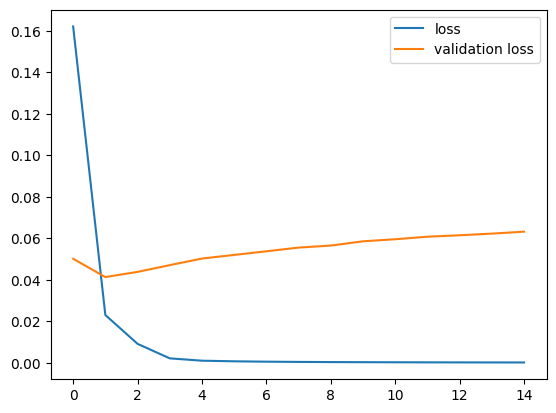

In [19]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

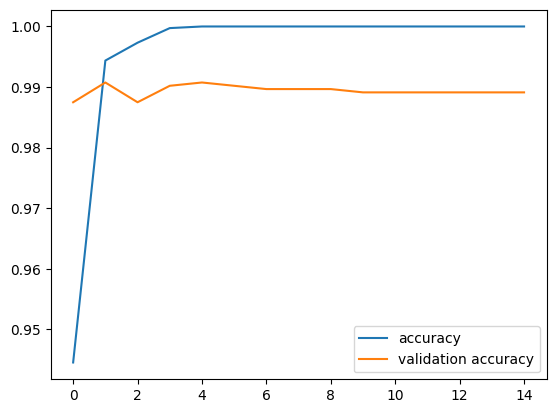

In [20]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="validation accuracy")
plt.legend()

# Spam Detection with CNN

In [26]:
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [28]:
i = Input(shape=(T,))
out = Embedding(input_dim=V+1, output_dim=D)(i)
out = Conv1D(32, kernel_size=3, activation="relu")(out)
out = MaxPool1D(strides=3)(out)
out = Conv1D(64, kernel_size=3, activation="relu")(out)
out = MaxPool1D(strides=3)(out)
out = Conv1D(128, kernel_size=3, activation="relu")(out)
out = GlobalMaxPooling1D()(out)

out = Dense(1, activation="sigmoid")(out)
model = Model(i, out)

In [29]:
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 189)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 189, 20)             │         143,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 187, 32)             │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 60, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 18, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,633 (689.97 KB)

 Trainable params: 176,633 (689.97 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
r = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=15)

Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8504 - loss: 0.3735 - val_accuracy: 0.9815 - val_loss: 0.0784
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9870 - loss: 0.0545 - val_accuracy: 0.9810 - val_loss: 0.0531
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9953 - loss: 0.0204 - val_accuracy: 0.9848 - val_loss: 0.0798
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0085 - val_accuracy: 0.9831 - val_loss: 0.1151
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9981 - loss: 0.0124 - val_accuracy: 0.9788 - val_loss: 0.1375
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9917 - loss: 0.0398 - val_accuracy: 0.9810 - val_loss: 0.1119
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9967 - loss: 0.0204 - val_accuracy: 0.9717 - val_loss: 0.2929
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9961 - loss: 0.0140 - val_accuracy: 0.

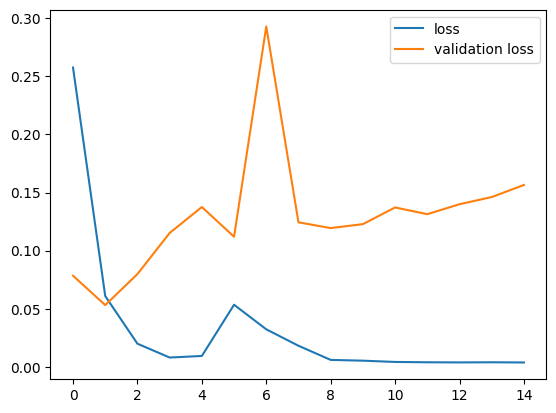

In [31]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

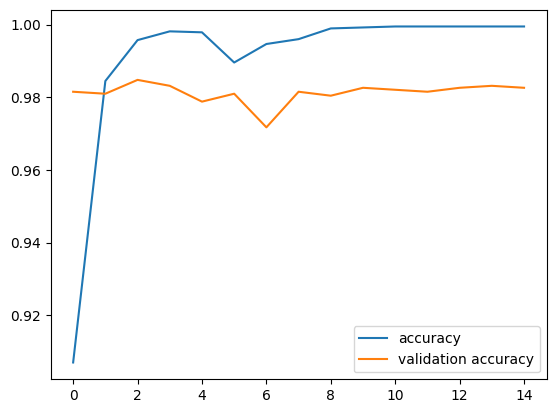

In [32]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="validation accuracy")
plt.legend()

In [40]:
# Misclassification:
predictions = model.predict(data_test).flatten()
predictions.shape, y_test.shape

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


((1839,), (1839,))

In [42]:
binary_predictions = np.round(predictions)

In [43]:
binary_predictions

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [63]:
misclassified = np.where(binary_predictions != y_test)[0]
misclassified

array([  43,  125,  135,  298,  364,  573,  604,  700,  714,  739,  780,
        894,  951, 1012, 1080, 1106, 1148, 1284, 1316, 1328, 1374, 1415,
       1439, 1524, 1671, 1681, 1727, 1738, 1809, 1820, 1824, 1829],
      dtype=int64)

In [81]:
random_idx = np.random.choice(misclassified)
print(df_test.iloc[random_idx], " -- was:", y_test[random_idx], "classified as:", binary_predictions[random_idx])

Bored housewives! Chat n date now! 0871750.77.11! BT-national rate 10p/min only from landlines!  -- was: 1 classified as: 0.0


In [97]:
classified = np.where(binary_predictions == y_test)[0]
random_idx = np.random.choice(classified)
print(df_test.iloc[random_idx], " -- was:", y_test[random_idx], "classified as:", binary_predictions[random_idx])

Feel like trying kadeem again? :V  -- was: 0 classified as: 0.0
